# First ICU Prediction using Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import interp, stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from utils.splits import set_two_splits
from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/work_dir/lr'),
 'dataset_csv': PosixPath('../data/first_icu_pred_proc.csv'),
 'modeldir': PosixPath('../data/work_dir/lr/models'),
 'min_freq': 3,
 'vectorizer_path': PosixPath('../data/work_dir/lr/tfidf_vectorizer.pkl'),
 'bc_threshold': 0.47}

## Functions

In [3]:
def top_words(vectorizer, clf, N):
  feature_names = vectorizer.get_feature_names()
  coefs_with_fns = sorted(zip(np.round(clf.coef_[0], 2), feature_names), reverse=True)
  negative = coefs_with_fns[:N]
  positive = coefs_with_fns[:-(N + 1):-1]

  print("Words associated with 'positive': ")
  for feat in positive:
      print(feat)

  print("Words associated with 'negative': ")
  for feat in negative:
      print(feat)

## LR Model Dev

In [4]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv)
ori_df.drop(['note'], axis=1, inplace=True)
df = set_two_splits(ori_df.copy(), 'test', seed=seed)

try:
  with open(args.vectorizer_path, 'rb') as f:
    vectorizer = pickle.load(f)
    x_train = pickle.load(f)
    x_test = pickle.load(f)
except FileNotFoundError:
  vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True,\
                                ngram_range=(2,2))
  x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
  x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])

  with open(fname, 'wb') as f:
    pickle.dump(vectorizer, f)
    pickle.dump(x_train, f)
    pickle.dump(x_test, f)

y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()

In [5]:
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

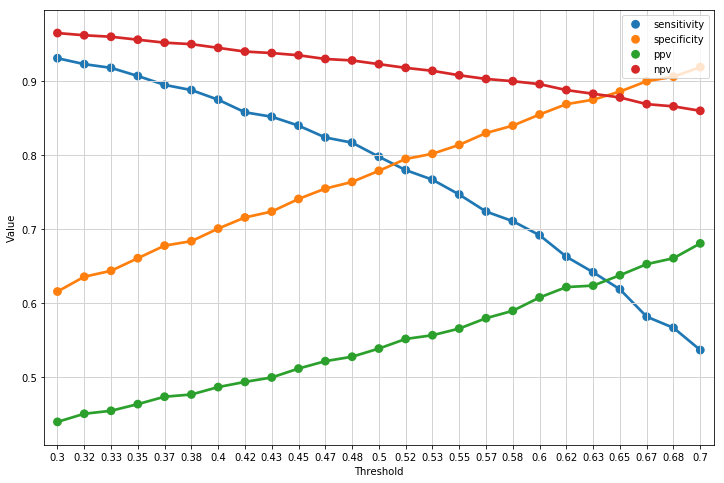

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [7]:
y_pred = (prob > 0.47).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.824
specificity,0.755
ppv,0.522
npv,0.930
f1,0.639
auroc,0.874
prevalence,0.245


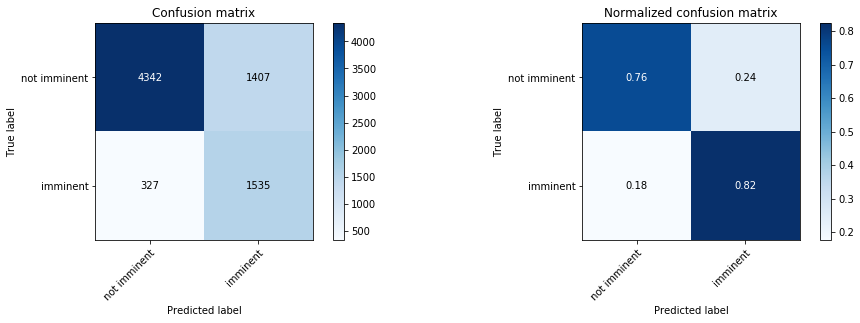

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['not imminent', 'imminent'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

In [9]:
# clf = pickle.load(open(args.modeldir/'sklearn-lr.pkl', 'rb'))
top_words(vectorizer, clf, 20)

Words associated with 'positive': 
(-6.83, 'intubated')
(-4.78, 'vent')
(-3.8, 'Progress')
(-3.77, 'sepsis')
(-3.58, 'OSH')
(-3.44, 'shock')
(-3.23, 'gtt')
(-3.15, 'ET')
(-3.15, 'ETT')
(-3.01, 'P')
(-2.97, 'support')
(-2.95, 'Endotracheal')
(-2.94, 'MULTIPLE')
(-2.89, 'INJURY')
(-2.8, 'sedated')
(-2.79, 'ABG')
(-2.74, 'endotracheal')
(-2.72, 'HYPOTENSION')
(-2.7, 'SEPSIS')
(-2.68, 'PEDESTRIAN')
Words associated with 'negative': 
(5.89, 'Transfer')
(5.11, 'floor')
(4.44, 'Age')
(4.15, 'transfer')
(3.73, 'FRACTURE')
(3.6, '_')
(3.46, 'TRANSFER')
(3.38, 'home')
(3.36, 'lobectomy')
(3.1, 'dementia')
(2.98, '2137')
(2.89, 'cancer')
(2.74, 'LOBE')
(2.71, 'melanoma')
(2.7, 'VALVE')
(2.68, '2118')
(2.65, 'MASS/SDA')
(2.6, 'nitro')
(2.56, 'hep')
(2.5, 'O2')


## Full Run

In [10]:
preds = []
targs = []
probs = []

for seed in range(100, 200):
  if seed % 10 == 0:
    print(f"Running classifier with seed {seed}")
  df = set_two_splits(ori_df.copy(), 'test', seed=seed)
  vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, ngram_range=(2,2))
  
  x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
  x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
  
  y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
  y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()
  targs.append(y_test)
  
  clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
  clf.fit(x_train, y_train)  
  pickle.dump(clf, open(args.modeldir/f'lr_seed_{seed}.pkl', 'wb'))
  
  pos_prob = clf.predict_proba(x_test)[:, 1]
  probs.append(pos_prob)
  
  y_pred = (pos_prob > args.bc_threshold).astype(np.int64)
  preds.append(y_pred)

with open(args.workdir/f'preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

Running classifier with seed 100
Running classifier with seed 110
Running classifier with seed 120
Running classifier with seed 130
Running classifier with seed 140
Running classifier with seed 150
Running classifier with seed 160
Running classifier with seed 170
Running classifier with seed 180
Running classifier with seed 190


## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

In [4]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

In [14]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam

Number of Runs: 100
Average Prevalence of positive class: 0.237

In [15]:
bam.get_avg_metrics()

,Value,Definition
sensitivity,0.893,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.621,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.422,"When it PREDICTS YES, how often is it correct?"
auroc,0.843,Indicates how well the model is capable of distinguishing between classes
npv,0.950,"When it PREDICTS NO, how often is it correct?"
f1,0.573,Harmonic mean of sensitivity and ppv


In [17]:
bam.get_avg_metrics(conf=0.95)

,Lower,Mean,Upper,Confidence,Definition
sensitivity,0.892,0.893,0.895,0.95,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.620,0.621,0.623,0.95,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.421,0.422,0.424,0.95,"When it PREDICTS YES, how often is it correct?"
npv,0.949,0.950,0.950,0.95,"When it PREDICTS NO, how often is it correct?"


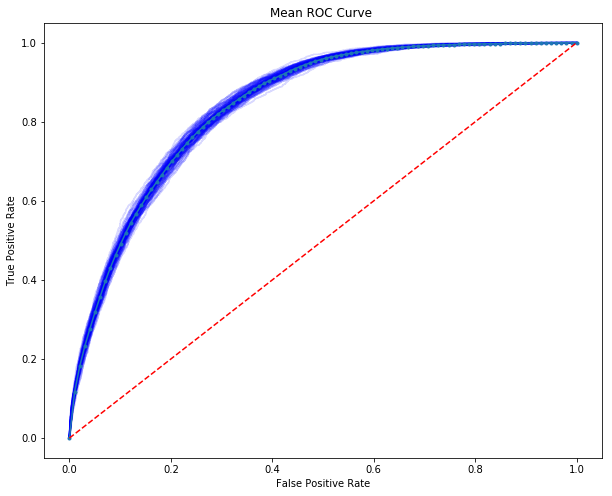

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

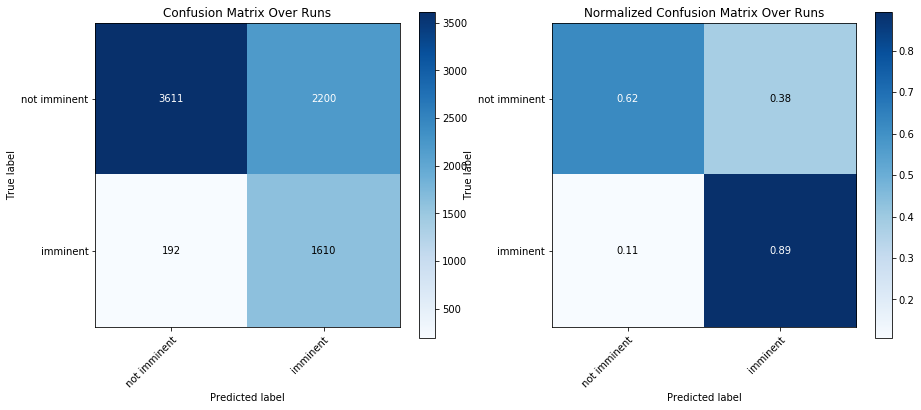

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()